# dracu_nest.ipynb
Compare the simulation times of the same network being run with NEST and Draculab.

The `nest` and `draculab` modules should be importable in the next cell.

In [1]:
import nest
import nest.topology as topp
#import draculab 
import numpy as np
import pylab
from matplotlib import pyplot as plt
import time
import cProfile
import pstats

In [2]:
%load_ext Cython

In [3]:
%%cython
import draculab

In [4]:
# --- NEST network ---
class nest_runner():

    def __init__(self, h=.1, N=10):
        #h = .1  # ms resolution
        #N = 10  # number of rows and columns
        nest.ResetKernel()
        nest.SetKernelStatus({'resolution': h, 'use_wfr':False})

        # create rate units and recording device
        lin_params = {'linear_summation': True,
                'mean': 0.,  # mean of the Gaussian white noise
                'std': 0.,   # standard deviation of the Gaussian white noise
                'tau': 20.,  # unit's time constant (milliseconds)
                'g': 1.,     # unit's gain
                'lambda': 1., # decay rate
                'rectify_output': False,
                'mult_coupling' : False,
                'rate': 0.}  # initial rate
        nest.CopyModel('lin_rate_ipn', 'linear_rate', params=lin_params)

        layer_dict = {"extent" : [float(N), float(N)], # the size of the layer in mm
              "rows" : N, # the number of rows in this layer ...
              "columns" : N, # ... and the number of columns
              "edge_wrap" : True, # periodic boundaries
              "elements" : "linear_rate"} # the element at each (x,y) coordinate in the grid

        self.lin_layer = topp.CreateLayer(layer_dict)

        conn_spec = {"connection_type":"divergent",
             "mask": {"circular":{"radius":1.5}},
             "kernel": 1.,
             "synapse_model": 'rate_connection_delayed',
             "delays": {'linear': {'c':2., 'a':.5}},
             "weights": .1,
             "allow_autapses": False }

        topp.ConnectLayers(self.lin_layer, self.lin_layer, conn_spec)

        # create/connect multimeter
        self.mm = nest.Create('multimeter')
        nest.SetStatus(self.mm, {'record_from': ['rate']})
        self.recorded = nest.GetNodes(self.lin_layer)[0]
        #recorded = topp.GetElement(self.lin_layer, [0,0])
        nest.Connect(self.mm, self.recorded, syn_spec={'delay':h})

    # create a sinusoidal input function
    def inp(self, amp, freq, t):
        return amp * np.sin(2.*freq*np.pi*(t))

    def run(self, sim_time):
        # simulate in a loop
        #sim_time = 100. # simulation time in ms
        step_len = .1   # duration of constant input
        n_steps = int(sim_time/step_len)
        inp_amp = -1.0
        inp_freq = 0.02
        stimd = self.recorded[0::2]

        start = time.time()
        for step in range(n_steps):
            nest.SetStatus(stimd, {'mean': self.inp(inp_amp, inp_freq, step*step_len)})
            nest.Simulate(step_len)
        end = time.time()
        elapsed = end-start
        print('Execution time: %f' % (elapsed))
        
        return elapsed, nest.GetStatus(self.mm)
    
    def plot(self, data):
        #data = nest.GetStatus(self.mm)
        senders = data[0]['events']['senders']
        rates = data[0]['events']['rate']
        times = data[0]['events']['times']
        T = times[np.where(senders == self.recorded[0])]
        fig = pylab.figure()
        pylab.plot(T, rates[np.where(senders == self.recorded[0])])
        pylab.plot(T, rates[np.where(senders == self.recorded[1])])
        pylab.plot(T, rates[np.where(senders == self.recorded[2])])

        pylab.show()

/home/z/programs/nest-simulator-2.16.0/lib/python3.5/site-packages/nest/lib/hl_api_helper.py:91: UserWarning: 
GetNodes is deprecated and will be removed in NEST 3.0. Use GIDCollection instead.
  warnings.warn('\n' + text)   # add LF so text starts on new line


Execution time: 0.925088
Thu May  9 13:21:29 2019    restats

         35055 function calls in 0.926 seconds

   Ordered by: cumulative time
   List reduced from 35 to 30 due to restriction <30>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    0.926    0.926 {built-in method builtins.exec}
        1    0.000    0.000    0.926    0.926 <string>:1(<module>)
        1    0.008    0.008    0.926    0.926 <ipython-input-4-5c4414ea08a8>:51(run)
     2001    0.005    0.000    0.908    0.000 /home/z/programs/nest-simulator-2.16.0/lib/python3.5/site-packages/nest/lib/hl_api_helper.py:227(stack_checker_func)
     3001    0.013    0.000    0.842    0.000 /home/z/programs/nest-simulator-2.16.0/lib/python3.5/site-packages/nest/__init__.py:83(catching_sli_run)
     3001    0.827    0.000    0.827    0.000 {method 'run' of 'pynestkernel.NESTEngine' objects}
     1000    0.002    0.000    0.712    0.001 /home/z/programs/nest-simulator-2.16.0/lib/p

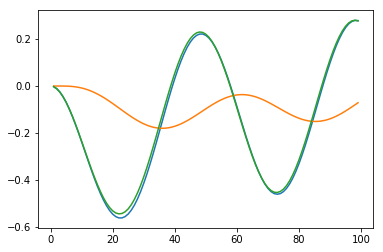

In [5]:
# Run with NEST
h = 0.01
N = 5
total_time = 100.
nesty = nest_runner(h,N)

cProfile.run('nest_t, data = nesty.run(total_time)', 'restats')
prof = pstats.Stats('restats')
prof.sort_stats('cumulative').print_stats(30)

#nest_t, data = nesty.run(total_time)
nesty.plot(data)

In [6]:
# --- draculab network ---
class dracu_runner():
    
    def __init__(self, h, N):
        net_params = {'min_delay': 1.,  # 1 ms
                      'min_buff_size': int(1./h) }  # h=nest's resolution

        self.net = draculab.network(net_params)

        # create rate units and recording device
        # N = number of rows and columns defined above
        lin_params = {'type': draculab.unit_types.noisy_linear,
              'init_val': 0., # initial rate
              'tau': 20.,     # unit's time constant (milliseconds)
              'lambda': 1.,   # decay rate
              'mu': 0.,       # mean of the Gaussian white noise
              'sigma': 0. }
        source_params = {'type': draculab.unit_types.source,
                 'init_val': 0., #0.06, # roughly the nest input in the first ms
                 'coordinates': np.array((0.,0.)),
                 'function': lambda t: None }

        geom = { 'shape':'sheet', 
             'extent':[N, N], # in millimeters
             'center':[0.,0.], 
             'arrangement':'grid',
             'rows':N, 
             'columns':N }

        topo = draculab.topology()

        self.lins = topo.create_group(self.net, geom, lin_params)

        conn_dict = {'connection_type': 'divergent',
             'mask': {"circular":{"radius":1.5}},
             'kernel': 1.,
             'delays': {'linear': {'c': 2., 'a':.5}},
             'edge_wrap': True,
             'boundary': {'center': np.array([0.,0.]), 'extent': [N, N]},
             'allow_autapses': False }
        syn_dict = {'type': draculab.synapse_types.static,
                    'init_w': 0.1 }

        topo.topo_connect(self.net, self.lins, self.lins, conn_dict, syn_dict)

        self.src = self.net.create(1, source_params)

        self.net.connect(self.src, self.lins[0::2], {'rule':'all_to_all', 'delay':1.},
                        {'type': draculab.synapse_types.static, 'init_w':1.})
        
    # create a sinusoidal input function
    def inp(self, amp, freq, t):
        return amp * np.sin(2.*freq*np.pi*t)

    def make_inp(self, amp, freq):
        return lambda t: self.inp(amp, freq, t)
    
    def run(self, sim_time):
        # simulate in a loop
        if __name__=='__main__':
            #sim_time = 100. # simulation time in ms
            step_len = 2.   # duration of constant input
            n_steps = int(sim_time/step_len)
            inp_amp = -1.0
            inp_freq = 0.02
            #times = np.array([])
            #activs = np.array([[] for _ in lins+src])
            self.net.units[self.src[0]].set_function(self.make_inp(inp_amp, inp_freq))

            start = time.time()
            """
            for step in range(n_steps):
                #net.units[lins[0]].mu = inp(inp_amp, inp_freq, step*step_len)
                net.units[src[0]].set_function( lambda t: inp(inp_amp, inp_freq, step*step_len))
                t, a, _ = net.run(step_len)
                times = np.append(times, t)
                activs = np.concatenate((activs, a), axis=1)
            """
            #import cProfile
            #import pstats
            #cProfile.run('times, activs, _ = net.run(sim_time)', 'restats')
            #prof = pstats.Stats('restats')
            #prof.sort_stats('cumulative').print_stats(30)
            #times, activs, _ = self.net.parallel_run(sim_time,10)
            #times, activs, _ = self.net.run(sim_time)
            times, activs, _ = self.net.flat_run(sim_time)
            end = time.time()
            elapsed = end - start
            print('Execution time: %f' % (elapsed))
            return elapsed, times, activs
    
    def plot(self, times, activs):
        figz = plt.figure()
        plt.plot(times, activs[self.lins[0]])
        plt.plot(times, activs[self.lins[1]])
        plt.plot(times, activs[self.lins[2]])
        plt.show()

Execution time: 1.529461
Thu May  9 13:21:38 2019    restats

         315757 function calls in 1.529 seconds

   Ordered by: cumulative time
   List reduced from 68 to 30 due to restriction <30>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    1.530    1.530 {built-in method builtins.exec}
        1    0.000    0.000    1.530    1.530 <string>:1(<module>)
        1    0.000    0.000    1.530    1.530 <ipython-input-6-6fd391dbe7b7>:58(run)
        1    0.003    0.003    1.529    1.529 /home/z/projects/draculab/network.py:1010(flat_run)
      100    0.025    0.000    1.505    0.015 /home/z/projects/draculab/network.py:975(flat_update)
     2500    0.691    0.000    0.905    0.000 /home/z/projects/draculab/units/units.py:1104(flat_exp_euler_update)
     2500    0.505    0.000    0.520    0.000 /home/z/projects/draculab/units/units.py:1019(upd_flat_inp_sum)
   250000    0.166    0.000    0.166    0.000 /home/z/projects/draculab/units/

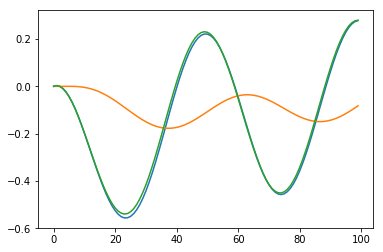

In [7]:
# run with draculab
dracu = dracu_runner(h, N)
#dracu_t, times, activs = dracu.run(total_time)
#"""

cProfile.run('dracu_t, times, activs = dracu.run(100)', 'restats')
prof = pstats.Stats('restats')
prof.sort_stats('cumulative').print_stats(30)
#"""
dracu.plot(times, activs)
#2500    0.118    0.000    1.925    0.001 {cython_utils.exp_euler_int}

In [8]:
def comp_plot(times, activs, data, lins, recorded):
    figz = plt.figure(figsize=(12,8))
    plt.plot(times, activs[lins[0]])
    plt.plot(times, activs[lins[1]])
    plt.plot(times, activs[lins[2]])
    senders = data[0]['events']['senders']
    rates = data[0]['events']['rate']
    ts = data[0]['events']['times']
    T = ts[np.where(senders == recorded[0])]
    plt.plot(T, rates[np.where(senders == recorded[N-1])], 'r*')
    plt.plot(T, rates[np.where(senders == recorded[N-2])], 'y+')
    plt.plot(T, rates[np.where(senders == recorded[N-3])], 'c+')
    plt.show()

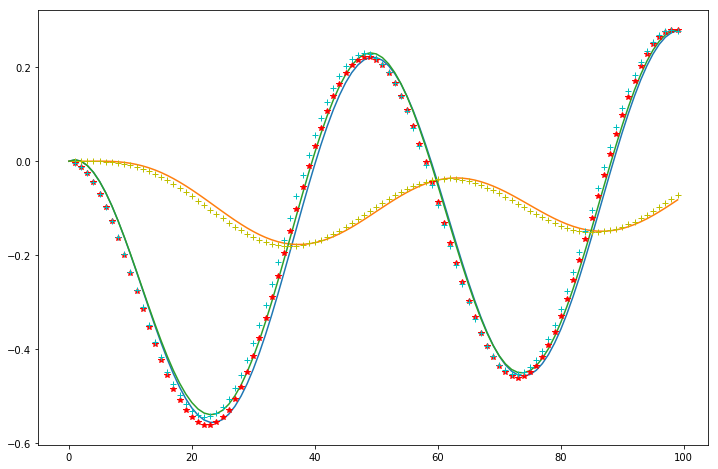

In [9]:
comp_plot(times, activs, data, dracu.lins, nesty.recorded)

In [ ]:
# compare execution times for various network sizes
h = 0.1
Ns = list(range(3,64,2))
sim_time = 100.
dracu_times = [0]*len(Ns)
nest_times = [0]*len(Ns)
for i, N in enumerate(Ns):
    nesty = nest_runner(h, N)
    nest_times[i], _ = nesty.run(sim_time)
    dracu = dracu_runner(h,N)
    dracu_times[i], _, _ = dracu.run(sim_time)
    
comp_fig = plt.figure(figsize=(16,8))
ax = comp_fig.gca()
ax.plot([n**2. for n in Ns], dracu_times, label='Flat Draculab', linewidth=4.)
ax.plot([n**2. for n in Ns], nest_times, label='NEST', linewidth=4.)
ax.set_ylabel('time [s]', fontsize='xx-large')
ax.set_xlabel('number of units', fontsize='xx-large')
ax.tick_params(labelsize=25)
plt.legend(bbox_to_anchor=(0.3,0.9), fontsize='xx-large')
plt.show()

Execution time: 0.329526
Execution time: 0.098310
Execution time: 0.399241
Execution time: 0.261413
Execution time: 0.505949
Execution time: 0.489371
Execution time: 0.645766
Execution time: 0.800625
Execution time: 0.814332
Execution time: 1.182421
Execution time: 1.019090
Execution time: 1.626209
Execution time: 1.271900
Execution time: 2.203934
Execution time: 1.551925
Execution time: 2.845453
Execution time: 1.859001
Execution time: 3.609576
Execution time: 2.226075
Execution time: 4.362782
Execution time: 2.593368
Execution time: 5.202275
Execution time: 3.014141
Execution time: 6.230649
Execution time: 3.464391
Execution time: 7.446214
Execution time: 3.950978
Execution time: 8.389935
Execution time: 4.495837
Execution time: 9.754871
Execution time: 5.039920
Execution time: 10.701309
Execution time: 5.629981
Execution time: 12.247874
Execution time: 6.282487
Execution time: 13.775840
Execution time: 7.000640
Execution time: 15.566593
Execution time: 7.880808
Execution time: 16.92

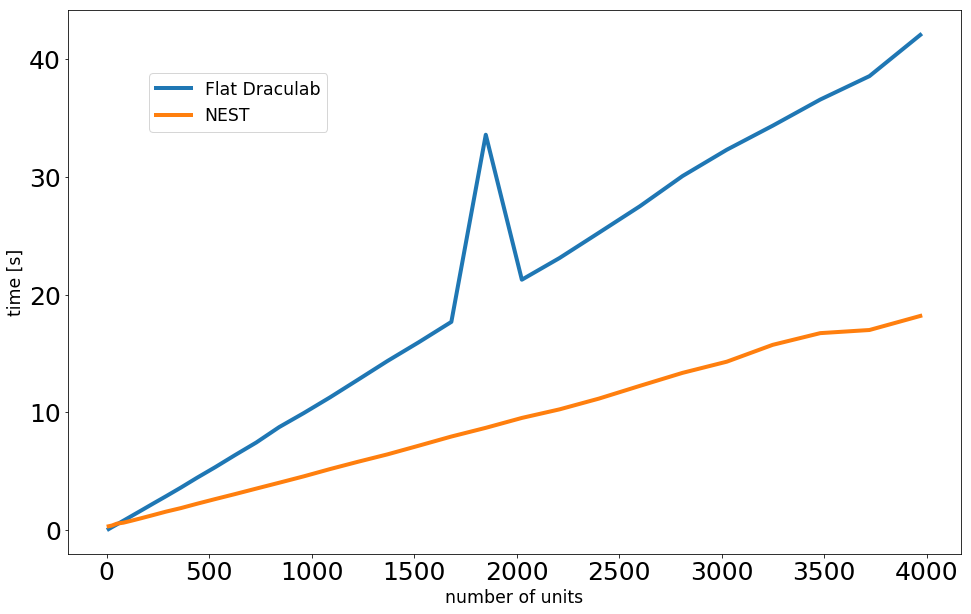

In [11]:
comp_fig = plt.figure(figsize=(16,10))
ax = comp_fig.gca()
ax.plot([n**2. for n in Ns], dracu_times, label='Flat Draculab', linewidth=4.)
ax.plot([n**2. for n in Ns], nest_times, label='NEST', linewidth=4.)
ax.set_ylabel('time [s]', fontsize='xx-large')
ax.set_xlabel('number of units', fontsize='xx-large')
ax.tick_params(labelsize=25)
plt.legend(bbox_to_anchor=(0.3,0.9), fontsize='xx-large')
plt.show()

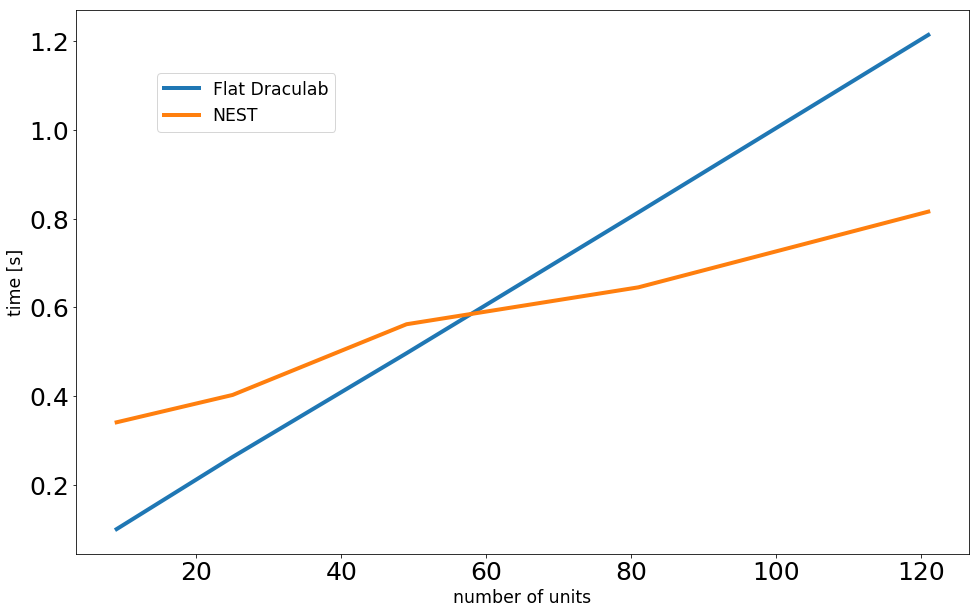

In [16]:
comp_fig = plt.figure(figsize=(16,10))
ax = comp_fig.gca()
L = 5
ax.plot([n**2. for n in Ns[0:L]], dracu_times[0:L], label='Flat Draculab', linewidth=4.)
ax.plot([n**2. for n in Ns[0:L]], nest_times[0:L], label='NEST', linewidth=4.)
ax.set_ylabel('time [s]', fontsize='xx-large')
ax.set_xlabel('number of units', fontsize='xx-large')
ax.tick_params(labelsize=25)
plt.legend(bbox_to_anchor=(0.3,0.9), fontsize='xx-large')
plt.show()

In [ ]:
# visualizing the connections 
net=dracu.net
%matplotlib notebook
# The 'notebook' backend is compatible with FuncAnimation
from matplotlib.animation import FuncAnimation
    
# the update function below will use these variables
all_coords = [u.coordinates for u in net.units]
source = [u.ID for u in net.units]
sink = [u.ID for u in net.units]
len_source = len(source)
len_sink = len(sink)
source_0 = source[0]
sink_0 = sink[0]

# flattening net.syns
all_syns = []
for syn_list in [net.syns[i] for i in sink]:
    all_syns.extend([s for s in syn_list if s.preID in source])

# getting lists with the coordinates of all source, sink units
source_coords = [u.coordinates for u in [net.units[i] for i in source]]
sink_coords = [u.coordinates for u in [net.units[i] for i in sink]]
source_x = [c[0] for c in source_coords]
source_y = [c[1] for c in source_coords]
sink_x = [c[0] for c in sink_coords]
sink_y = [c[1] for c in sink_coords]

# id2src[n] maps the unit with network id 'n' to its index in the 'source' list
id2src = np.array([1e8 for _ in range(len(net.units))], dtype=int) # 1e8 if not in source
for src_idx, net_idx in enumerate(source):
    id2src[net_idx] = src_idx
# id2snk[n] maps the unit with network id 'n' to its index in the 'sink' list
id2snk = np.array([1e8 for _ in range(len(net.units))], dtype=int) # 1e8 if not in sink
for snk_idx, net_idx in enumerate(sink):
    id2snk[net_idx] = snk_idx

# setting colors
std_src = [0., 0.5, 0., 0.5]
std_snk = [0.5, 0., 0., 0.5]
big_src = [0., 0., 1., 1.]
big_snk = [0., 0., 1., 1.]

# constructing figure, axes, path collections
conn_fig = plt.figure(figsize=(10,6))
ax1 = conn_fig.add_axes([0.02, 0.01, .47, 0.95], frameon=True, aspect=1)
ax2 = conn_fig.add_axes([0.51, 0.01, .47, 0.95], frameon=True, aspect=1)
src_col1 = ax1.scatter(source_x, source_y, s=2, c=std_src)
snk_col1 = ax1.scatter(sink_x, sink_y, s=2, c=std_snk)
src_col2 = ax2.scatter(source_x, source_y, s=2, c=std_src)
snk_col2 = ax2.scatter(sink_x, sink_y, s=2, c=std_snk)
ax1.set_title('sent connections')
ax2.set_title('received connections')
ax2.set_yticks([])


# At each frame we'll visualize the connections arising from a single unit
def update(frame): 
    sou_u = frame%len_source # source unit whose receivers we'll visualize
    snk_u = frame%len_sink # sink unit whose senders we'll visualize

    # PLOTTING THE RECEIVERS OF sou_u ON THE LEFT AXIS
    source_sizes = np.tile(2, len_source)
    sink_sizes = np.tile(2, len_sink)
    source_colors = np.tile(std_src,(len_source,1))
    sink_colors = np.tile(std_snk, (len_sink,1))
    source_sizes[sou_u] = 50
    source_colors[sou_u] = big_src
    # getting targets of projections from the unit 'sou_u'
    targets = id2snk[ [syn.postID for syn in all_syns if id2src[syn.preID] == sou_u ] ]
    # setting the colors and sizes
    sink_colors[targets] = big_snk
    sink_sizes[targets] = 15
    src_col1.set_sizes(source_sizes)
    #ax1.get_children()[0].set_sizes(source_sizes)   # sizes for the source units
    snk_col1.set_sizes(sink_sizes)
    src_col1.set_color(source_colors)
    snk_col1.set_color(sink_colors)

    # PLOTTING THE SENDERS TO snk_u ON THE RIGHT AXIS
    source_sizes = np.tile(2, len_source)
    sink_sizes = np.tile(2, len_sink)
    source_colors = np.tile(std_src, (len_source,1))
    sink_colors = np.tile(std_snk, (len_sink,1))
    sink_sizes[snk_u] = 50
    sink_colors[snk_u] = big_snk
    # getting senders of projections to the unit 'snk_u
    senders = id2src[ [syn.preID for syn in all_syns if id2snk[syn.postID] == snk_u] ]
    # setting the colors and sizes
    source_colors[senders] = std_src
    source_sizes[senders] = 15
    src_col2.set_sizes(source_sizes)
    snk_col2.set_sizes(sink_sizes)
    src_col2.set_color(source_colors)
    snk_col2.set_color(sink_colors)

    return ax1, ax2,

animation = FuncAnimation(conn_fig, update, interval=500, blit=True)
plt.show()